ライブラリのインポート

In [2]:
#!/usr/bin/env python
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

関数の定義

In [3]:
def logdiff(x):
    x = np.log(x)
    x1 = list(np.r_[x,0])
    del x1[0]
    x1 = np.array(x1)
    x2 = list(x1 - x)
    N = len(x2)
    del x2[N-1]
    x2 = np.array(x2)
    return x2

def cofactor_matrix(X,number):
    M = np.shape(X)[1]
    index = np.ones(M, dtype=bool)
    index[number] = False
    X_2 = X[index]
    X_3 = X_2.T[index]
    X_3 = X_3.T
    
    Y_1 = X[:,number]
    Y_2 = np.delete(Y_1,number)
    return X_3,Y_2

def soft_thre(x,lam):
    if x > 0 and lam < np.abs(x):
        s = x - lam
    elif x < 0 and lam < np.abs(x):
        s = x + lam
    else:
        s = 0
    
    return s

def inf_debug(matrix,name):
    if np.any(np.isinf(matrix)):
        print '!!!!!!!!!!!!!! inf in {} !!!!!!!!!!!!!!!!'.format(name)
        print np.where(matrix==np.float(inf))
        print matrix[np.where(matrix==np.float(inf))]


def update_W12(W,S,num,rho,lam):
    D = np.shape(W)[1]
    
    W_11,W_12 = cofactor_matrix(W,num)
    S_11,S_12 = cofactor_matrix(S,num)
    
    l,P = np.linalg.eig(W_11)
    L = np.diag(np.sqrt(l))
    W_11_sqrt = np.dot(np.dot(P,L),np.linalg.inv(P))
    #np.dot(P.T,P)
    #W_check = np.dot(W_11_sqrt,W_11_sqrt)
    #W_11 - W_check
    
    b = np.dot(np.linalg.inv(W_11_sqrt),S_12)
    
    D2 = np.shape(W_11)[1]
    
    beta_old = np.zeros(D2)
    beta_new = np.copy(beta_old)

    #CD
    for k in np.arange(D2):
        index = np.ones(D2, dtype=bool)
        index[k] = False
        
        W_kj,no_use = cofactor_matrix(W_11,k)
        
        term1 = S_12[k] - sum(np.dot(W_kj,beta_old[index]))
        term2 = 1. / W_11[k][k]
        #print 'term2:',term2 #debug
        beta_new[k] = soft_thre(term1,lam) * term2
        #print 'beta_new',beta_new[k] #debug
        beta_old = np.copy(beta_new)
    #print(beta_new)
    
    W_12_new = np.dot(W_11,beta_new)
    W_newcolum = np.insert(W_12_new,[num],np.diag(W)[num])
    W_new = np.copy(W)
    W_new[:,num] = W_newcolum
    W_new[num,:] = W_newcolum
    #print(W_new)
    return W_new

#this function return just 0 or 1 matrix
def get_edge_matrix(W):
    M = np.shape(W)[1]
    i_index, j_index = np.nonzero(W)
    edge = np.zeros((M,M))
    for (i,j) in zip(i_index,j_index):
        edge[i][j] = 1
    
    return edge

def plot_graph(W,color,name=None):
    plt.figure()
    D = np.shape(W)[1]
    G = nx.Graph()
    for i in np.arange(D):
        G.add_node(i)
    
    i_index, j_index = np.nonzero(W)
    for (i,j) in zip(i_index,j_index):
        G.add_edge(i, j)
    
    labels={}
    for i in np.arange(D):
        labels[i] = str(i)
    
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_color=color)
    nx.draw_networkx_edges(G,pos)
    nx.draw_networkx_labels(G,pos,labels,font_size=16)
    #title(name)

def cor_mat(S):
    std_array = np.array(np.sqrt([np.diag(S)])).T
    s = np.dot(std_array,std_array.T)
    cor_matrix = S/s
    return s,cor_matrix

def heatmap(matrix,title=None):
    x = np.arange(matrix.shape[0])
    y = np.arange(matrix.shape[1])
    X,Y = np.meshgrid(x,y)
    fig, ax = plt.subplots()
    ax.pcolor(X,Y,matrix)
    plt.title(title)
    #ax.pcolor(X,Y,matrix, cmap=plt.cm.Blues)
    fig.show()

#This function return the submatrix which the non diagonal elements are not zero.
def extract_nonzero(matrix):
    nonzeroindex = np.where(np.sum(matrix,0)-np.diag(matrix) > 0)
    temp = matrix[nonzeroindex]
    temp = temp.T[nonzeroindex]
    return nonzeroindex,temp

def cov_lasso_optim(S,N,M,rho,lam_rho_ratio=0.08):
    W = S + np.diag(np.tile(rho,M))
    for j in np.arange(1):
        for i in np.arange(M):
            if i == 0 and j == 0:
                W_old = np.copy(W)
            
            W_new = update_W12(W_old,S,i,rho,lam=rho*lam_rho_ratio) #rho=0.1,lam=rho*0.08 looks good
            #If we choose under rho=0.1,lam=rho*0.074, W_new includes inf
            W_old = np.copy(W_new)
    print "W_new : ",W_new
    return W_new

データのロード

In [4]:
data = np.loadtxt("/Users/kazeto/Desktop/nikkei/logdiffdata.csv",delimiter=",")
#資産数185
#データ数199
#期間2000/2/29 ~ 2016/9/30　月次データ

初期値などの設定

In [5]:
N = data.shape[0]
M = data.shape[1]
S = np.dot(data.T,data) / N
rho = 0.1

必要ならば相関行列の計算

In [6]:
#Caluculate corelation matrix
std_array1 = np.array(np.sqrt([np.diag(S)])).T
s1 = np.dot(std_array1,std_array1.T)
cor_mat1 = S/s1
print('correlation',cor_mat1)

('correlation', array([[ 1.        ,  0.32221652,  0.3122585 , ...,  0.17632497,
         0.13936895,  0.07988168],
       [ 0.32221652,  1.        ,  0.68303968, ...,  0.11259354,
         0.14733477,  0.17199066],
       [ 0.3122585 ,  0.68303968,  1.        , ...,  0.16021898,
         0.23574202,  0.0984805 ],
       ..., 
       [ 0.17632497,  0.11259354,  0.16021898, ...,  1.        ,
         0.30897088,  0.31677112],
       [ 0.13936895,  0.14733477,  0.23574202, ...,  0.30897088,
         1.        ,  0.16193039],
       [ 0.07988168,  0.17199066,  0.0984805 , ...,  0.31677112,
         0.16193039,  1.        ]]))


共分散のLASSO推定

In [67]:
W_new = cov_lasso_optim(S=S,rho=rho,N=N,M=M)

W_new :  [[ 0.10948807  0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.10884966  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.10843681 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.11444265  0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.11681324  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.12725006]]


エッジ行列の作成(ネットワークグラフのプロット用）

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


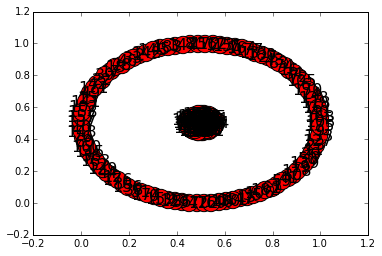

In [68]:
edge = get_edge_matrix(W_new)
non = np.nonzero(W_new)
print(edge)

plot_graph(W_new,'r')

対角成分以外にも値が残っている部分行列を取り出す（チェック用）

In [69]:
nonzeroindex, nonzeromatrix = extract_nonzero(W_new)
print(nonzeromatrix.shape)

(83, 83)


経験共分散行列(S)、スパースに推定した共分散行列(W_new)、W_newの部分行列のヒートマップ

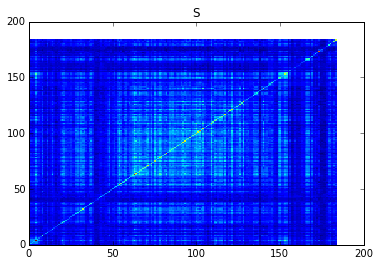

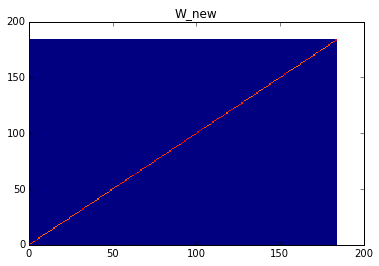

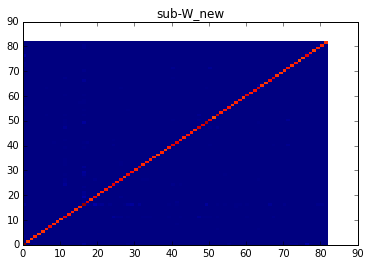

In [70]:
heatmap(S,"S")
heatmap(W_new,"W_new")
heatmap(nonzeromatrix,"sub-W_new")

Rによるパッケージと比べてみる。
rhoを増やすとものすごい勢いで対角成分以外が０に落ちていっているので、同じ挙動を示している。

In [32]:
for i in np.arange(20):
    Rname ='./W_R/glasso_W_rho' + str(i) + '.csv'
    W_R = np.loadtxt(Rname,delimiter=",",skiprows=1)
    #heatmap(W_R)
    #title('rho=' + str(i))
    nonzeroindex, nonzeromatrix = extract_nonzero(W_R)
    print len(nonzeroindex[0])

185
35
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


ポートフォリオ構築用の関数の定義

In [7]:
#portfolio optimization
import cvxopt
from cvxopt import matrix,solvers,sparse,printing
def mean_variance_model_optim(data,S,r0,to_=150):
    d = data[0:to_,]
    N = d.shape[0]
    #S = np.dot(d.T,d) / N
    r = np.mean(d,0)
    minus_r = np.matrix(-np.copy(r))
    n = len(r)
    P = matrix(np.copy(S))
    q = matrix(0.0,(n,1))
    I = matrix(0.0,(n,n))
    I[::n+1] = -1.0
    G = sparse([I])
    A = sparse([matrix(minus_r),matrix(1.0,(1,n))])
    b = matrix([-r0,1])
    h = matrix(np.zeros(n))
    sol = solvers.qp(P,q,G,h,A,b)
    print sol['x']
    print sum(cvxopt.mul(sol['x'],matrix(r)))
    print sum(sol['x'])
    return sol,r

def split_data(d,split_t):
    d1 = d[0:split_t,:]
    d2 = d[split_t:,:]
    print "d1.shape : ",d1.shape
    print "d2.shape : ",d2.shape
    return d1,d2

def window_data(d,start,window_size=100):
    return d[start:start+window_size,:]

ローリングによるポートフォリオの評価。

経験共分散行列を使用した時と推定したスパースな共分散行列の比較。

In [ ]:
d = data
start = 0
window_size = 100
r0 = 0.01
test_retrun_emp_array = []
test_return_lasso_array = []
emp_true_variance_array = []
lasso_true_variance_array = []
sol_enp_output_array = []
sol_lasso_output_array = []
matrix_repr = printing.matrix_str_default
for start in np.arange(len(d) - window_size -1):
    print "----------- step : {} -----------".format(start)
    d_window = window_data(d,start,window_size)
    S_window = np.dot(d_window.T,d_window) / d_window.shape[0]
    N_window = d_window.shape[0]
    M_window = d_window.shape[1]
    W_window = cov_lasso_optim(S=S_window,N=N_window,M=M_window,rho=0.4,lam_rho_ratio=0.2)
    sol_empirical,r1 = mean_variance_model_optim(d_window,S_window,r0=r0)
    sol_lasso,r2 = mean_variance_model_optim(d_window,W_window,r0=r0)
    sol_enp_output = sol_empirical['x']
    sol_lasso_output = sol_lasso['x']
    testdata = d[start+window_size+1,:]
    test_retrun_emp = np.dot(testdata,sol_enp_output)[0]
    test_return_lasso = np.dot(testdata,sol_lasso_output)[0]
    
    test_retrun_emp_array.append(test_retrun_emp)
    test_return_lasso_array.append(test_return_lasso)
    sol_enp_output_array.append(np.array(sol_enp_output))
    sol_lasso_output_array.append(np.array(sol_lasso_output))

    #calculate true(base) variance.
    emp_true_variance = np.std(np.dot(d[start + window_size:,:],sol_enp_output))
    lasso_true_variance = np.std(np.dot(d[start + window_size:,:],sol_lasso_output))
    emp_true_variance_array.append(emp_true_variance)
    lasso_true_variance_array.append(lasso_true_variance)
    print "N,M : ",N_window,M_window
    print "S : ",S_window
    #print "sol_enp_output : ",np.array(sol_enp_output)
    #print "sol_lasso_output : ",np.array(sol_lasso_output)

/usr/local/lib/python2.7/site-packages/matplotlib/legend.py:319: UserWarning: Unrecognized location "bottom left". Falling back on "best"; valid locations are
	right
	center left
	upper right
	lower right
	best
	center
	lower left
	center right
	upper left
	upper center
	lower center

  % (loc, '\n\t'.join(six.iterkeys(self.codes))))


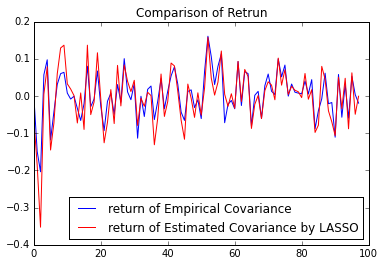

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(test_retrun_emp_array, 'b', label="return of Empirical Covariance")
ax.plot(test_return_lasso_array, 'r', label="return of Estimated Covariance by LASSO")
plt.title("Comparison of Retrun")
ax.legend(loc = 'bottom left')
fig.show()

In [47]:
print "Empirical Mean : ", np.mean(test_retrun_emp_array) * 12
print "LASSO Mean : ", np.mean(test_return_lasso_array) * 12
print "Empirical Std : ", np.std(test_retrun_emp_array) * np.sqrt(12)
print "LASSO Std : ", np.std(test_return_lasso_array) * np.sqrt(12)

emp_diff = np.array(emp_true_variance_array) - np.array(test_retrun_emp_array)
lasso_diff = np.array(lasso_true_variance_array) - np.array(test_return_lasso_array)

print "Empirical Diff : ",np.mean(emp_diff)
print "LASSO Diff : ",np.mean(lasso_diff)

Empirical Mean :  0.038726139991
LASSO Mean :  -0.0297495059452
Empirical Std :  0.208057546058
LASSO Std :  0.262274253143
Empirical Diff :  0.0487286557474
LASSO Diff :  0.0639481802179


jsonデータへ保存

In [49]:
back_up_dict = {}
back_up_dict['test_retrun_emp_array'] = test_retrun_emp_array
back_up_dict['test_return_lasso_array'] = test_return_lasso_array
back_up_dict['expected_return_emp'] = np.mean(test_retrun_emp_array)
back_up_dict['expected_return_lasso'] = np.mean(test_return_lasso_array)
back_up_dict['risk_emp'] = np.std(test_retrun_emp_array) * 12
back_up_dict['risk_lasso'] = np.std(test_return_lasso_array) * 12
back_up_dict['emp_true_variance_array'] = emp_true_variance_array
back_up_dict['lasso_true_variance_array'] = lasso_true_variance_array
back_up_dict['emp_diff'] = list(emp_diff)
back_up_dict['lasso_diff'] = list(lasso_diff)
back_up_dict['mean_emp_diff'] = np.mean(emp_diff)
back_up_dict['mean_lasso_diff'] = np.mean(lasso_diff)
back_up_dict['sol_enp_output_array'] = np.array(sol_enp_output_array)
back_up_dict['sol_lasso_output_array'] = np.array(sol_lasso_output_array)

import json
#Save to json data
#f = open("/Users/kazeto/Desktop/nikkei/output/0to185_w100_output.json", "w")
#json.dump(back_up_dict, f)

#Load from json data
#f = open("/Users/kazeto/Desktop/nikkei/0to185_w100_output.json")
#backup = json.load(f)


概要を知るために1期間でやってみる。

In [ ]:
traindata, testdata = split_data(data,150)
sol_empirical,r1 = mean_variance_model_optim(traindata,S,r0=0.01)
sol_enp_output = sol_empirical['x']
sol_lasso,r2 = mean_variance_model_optim(traindata,W_new,r0=0.01)
sol_lasso_output = sol_lasso['x']
cvxopt.matrix_repr = printing.matrix_str_default
#cvxopt.spmatrix_repr = printing.spmatrix_str_default
sol_emp = np.array(sol_enp_output)
sol2_lasso = np.array(sol_lasso_output)

test_retrun_emp = np.dot(testdata, sol_emp)
test_return_lasso = np.dot(testdata, sol2_lasso)
#print np.mean(test_retrun_emp)
#print np.mean(test_return_lasso)

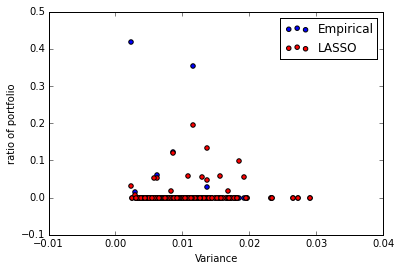

In [61]:
a = np.diag(S)
b = sol_emp
b2 = sol2_lasso

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(a,b,c='b',label="Empirical")
ax.scatter(a,b2,c='r',label="LASSO")
ax.legend(loc="upper right")
ax.set_xlabel("Variance")
ax.set_ylabel("ratio of portfolio")
fig.show()

TOPIX core30でやってみる

In [8]:
core = np.loadtxt("/Users/kazeto/Desktop/nikkei/core30_logdiffdata.csv",delimiter=",")

In [9]:
d = np.copy(core)

In [10]:
start = 0
window_size = 100
r0 = 0.01
test_retrun_emp_array = []
test_return_lasso_array = []
emp_true_variance_array = []
lasso_true_variance_array = []
sol_enp_output_array = []
sol_lasso_output_array = []
matrix_repr = printing.matrix_str_default
for start in np.arange(len(d) - window_size -1):
    print "----------- step : {} -----------".format(start)
    d_window = window_data(d,start,window_size)
    S_window = np.dot(d_window.T,d_window) / d_window.shape[0]
    N_window = d_window.shape[0]
    M_window = d_window.shape[1]
    W_window = cov_lasso_optim(S=S_window,N=N_window,M=M_window,rho=0.4,lam_rho_ratio=0.2)
    sol_empirical,r1 = mean_variance_model_optim(d_window,S_window,r0=r0)
    sol_lasso,r2 = mean_variance_model_optim(d_window,W_window,r0=r0)
    sol_enp_output = sol_empirical['x']
    sol_lasso_output = sol_lasso['x']
    testdata = d[start+window_size+1,:]
    test_retrun_emp = np.dot(testdata,sol_enp_output)[0]
    test_return_lasso = np.dot(testdata,sol_lasso_output)[0]
    
    test_retrun_emp_array.append(test_retrun_emp)
    test_return_lasso_array.append(test_return_lasso)
    sol_enp_output_array.append(np.array(sol_enp_output))
    sol_lasso_output_array.append(np.array(sol_lasso_output))

    #calculate true(base) variance.
    emp_true_variance = np.std(np.dot(d[start + window_size:,:],sol_enp_output))
    lasso_true_variance = np.std(np.dot(d[start + window_size:,:],sol_lasso_output))
    emp_true_variance_array.append(emp_true_variance)
    lasso_true_variance_array.append(lasso_true_variance)
    print "N,M : ",N_window,M_window
    #print "S : ",S_window
    #print "sol_enp_output : ",np.array(sol_enp_output)
    #print "sol_lasso_output : ",np.array(sol_lasso_output)

----------- step : 0 -----------
W_new :  [[ 0.40508559  0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.4062189   0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.40364716  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.40543984  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.  

/usr/local/lib/python2.7/site-packages/matplotlib/legend.py:319: UserWarning: Unrecognized location "bottom left". Falling back on "best"; valid locations are
	right
	center left
	upper right
	lower right
	best
	center
	lower left
	center right
	upper left
	upper center
	lower center

  % (loc, '\n\t'.join(six.iterkeys(self.codes))))
/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


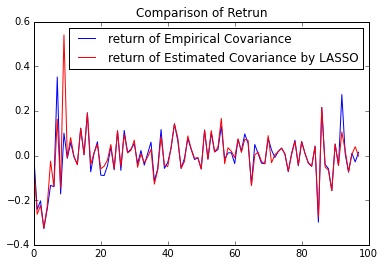

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(test_retrun_emp_array, 'b', label="return of Empirical Covariance")
ax.plot(test_return_lasso_array, 'r', label="return of Estimated Covariance by LASSO")
plt.title("Comparison of Retrun")
ax.legend(loc = 'bottom left')
fig.show()

In [21]:
print "Empirical Mean : ", np.mean(test_retrun_emp_array) * 12
print "LASSO Mean : ", np.mean(test_return_lasso_array) * 12
print "Empirical Std : ", np.std(test_retrun_emp_array) * np.sqrt(12)
print "LASSO Std : ", np.std(test_return_lasso_array) * np.sqrt(12)

emp_diff = np.array(emp_true_variance_array) - np.array(test_retrun_emp_array)
lasso_diff = np.array(lasso_true_variance_array) - np.array(test_return_lasso_array)

print "Empirical Diff : ",np.mean(emp_diff)
print "LASSO Diff : ",np.mean(lasso_diff)

Empirical Mean :  -0.021565638504
LASSO Mean :  0.0142379594398
Empirical Std :  0.35578624162
LASSO Std :  0.107162638429
Empirical Diff :  0.0790082044493
LASSO Diff :  0.0736487182915


期待平均はLASSOが勝っている。標準誤差は若干大きい。

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


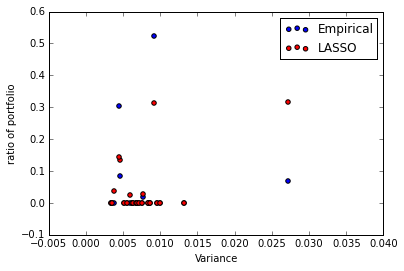

In [20]:
S_core = np.dot(d.T,d) / d.shape[0]
a = np.diag(S_core)
b = np.array(sol_enp_output)
b2 = np.array(sol_lasso_output)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(a,b,c='b',label="Empirical")
ax.scatter(a,b2,c='r',label="LASSO")
ax.legend(loc="upper right")
ax.set_xlabel("Variance")
ax.set_ylabel("ratio of portfolio")
fig.show()

疑問点1

共分散が消えるとポートフォリオの分散は、共分散の分だけ小さくなると思っていたが、実際に計算してみると、分散が大きくなる傾向になる。これはどうしてだろうか。

疑問点２

In [73]:
print sol_emp
#2次計画法を解くと、こんな感じで各比率が完全には0にならないのだが、最適化手法を変えるとうまく０に落ちてくれるのだろうか。
#もしくは、ある値以下の比率を全て0にして、また合計が1になるように正規化してもいいのだろうか。

[[  2.58375548e-09]
 [  2.92543705e-09]
 [  2.59876141e-09]
 [  2.40036927e-09]
 [  8.86895628e-10]
 [  1.84285297e-09]
 [  3.06208572e-09]
 [  2.46345737e-09]
 [  3.52833227e-01]
 [  4.05338137e-09]
 [  3.69345264e-09]
 [  1.65549181e-09]
 [  1.44457844e-08]
 [  2.21261877e-09]
 [  9.32416469e-10]
 [  4.89308114e-09]
 [  3.52223702e-09]
 [  4.55480392e-09]
 [  6.13828500e-02]
 [  1.63443487e-09]
 [  1.47960270e-09]
 [  2.07258062e-09]
 [  1.31434917e-09]
 [  3.79334537e-09]
 [  2.62971575e-09]
 [  1.81191977e-09]
 [  1.57470016e-09]
 [  1.80150955e-09]
 [  2.00895650e-09]
 [  1.29501483e-09]
 [  2.76964746e-09]
 [  1.09596874e-09]
 [  1.19204206e-09]
 [  1.92987237e-09]
 [  2.17734376e-09]
 [  1.70536288e-09]
 [  1.00241567e-09]
 [  2.09857778e-09]
 [  3.66192916e-09]
 [  2.64879944e-09]
 [  2.10473248e-09]
 [  2.67251037e-09]
 [  2.85385458e-09]
 [  1.77774867e-09]
 [  2.99619411e-09]
 [  4.06848505e-09]
 [  3.62940156e-09]
 [  1.16200020e-09]
 [  2.09002307e-09]
 [  2.51039481e-09]
